In [164]:
import pandas as pd

data = pd.read_csv("/Users/nguyendinhhuy/Desktop/Ny Project/Project 3/w15_cluster.csv")
data['interval'] = data['Timesteps']

total_samples = len(data)
train_percentage = 0.9
valid_percentage = 0.065
test_percentage = 0.035

train_size = int(total_samples * train_percentage)
valid_size = int(total_samples * valid_percentage)
test_size = total_samples - train_size - valid_size

train_size = train_size - (train_size % 96)
valid_size = valid_size - (valid_size % 96)
test_size = total_samples - train_size - valid_size

train_size = total_samples - valid_size - test_size

train_data = data.iloc[:train_size]
valid_data = data.iloc[train_size:train_size + valid_size]
test_data = data.iloc[train_size + valid_size:train_size + valid_size + test_size]

train_data.to_csv("train_shalun15_c.csv", index=False)
valid_data.to_csv("valid_shalun15_c.csv", index=False)
test_data.to_csv("test_shalun15_c.csv", index=False)

print(f"Total samples: {total_samples}")
print(f"Train size (divisible by 96): {train_size}")
print(f"Valid size (divisible by 96): {valid_size}")
print(f"Test size (divisible by 96): {test_size}")


Total samples: 16896
Train size (divisible by 96): 15168
Valid size (divisible by 96): 1056
Test size (divisible by 96): 672


In [165]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

train_data = pd.read_csv('train_shalun15_c.csv')
val_data = pd.read_csv('valid_shalun15_c.csv')
test_data = pd.read_csv('test_shalun15_c.csv')

encoder_features = [ 'clearsky_ghi', 'uv_index', 'D_lw1', 'D_lw2', 'D_lw3', 'D_lw4', 
                    'D_lw5', 'D_lw6', 'D_lw7', 'zenith', 'D_15min',
                    'Timesteps','day','month','hour','minute']
decoder_features = ['clearsky_ghi', 'uv_index', 'D_lw1', 'D_lw2', 'D_lw3', 'D_lw4', 
                    'D_lw5', 'D_lw6', 'D_lw7', 'zenith', 'D_15min',
                    'Timesteps','day','month','hour','minute']  
target_column = ['kW']  #
def create_one_step_data(data, enc_features, dec_features, target, time_steps=1):
    X_enc, X_dec, y = [], [], []
    for i in range(time_steps, len(data)):
        X_enc.append(data[enc_features].iloc[i - time_steps:i].values.flatten())
        
        X_dec.append(data[dec_features].iloc[i - time_steps:i].values.flatten())
        
        y.append(data[target].iloc[i].values)
    return np.array(X_enc), np.array(X_dec), np.array(y)

time_steps = 1  
X_enc_train, X_dec_train, y_train = create_one_step_data(train_data, encoder_features, decoder_features, target_column, time_steps)
X_enc_val, X_dec_val, y_val = create_one_step_data(val_data, encoder_features, decoder_features, target_column, time_steps)
X_enc_test, X_dec_test, y_test = create_one_step_data(test_data, encoder_features, decoder_features, target_column, time_steps)

scaler_enc = StandardScaler()
scaler_dec = StandardScaler()
scaler_y = StandardScaler()

X_enc_train = scaler_enc.fit_transform(X_enc_train)
X_dec_train = scaler_dec.fit_transform(X_dec_train)
y_train = scaler_y.fit_transform(y_train)

X_enc_val = scaler_enc.transform(X_enc_val)
X_dec_val = scaler_dec.transform(X_dec_val)
y_val = scaler_y.transform(y_val)

X_enc_test = scaler_enc.transform(X_enc_test)
X_dec_test = scaler_dec.transform(X_dec_test)
y_test = scaler_y.transform(y_test)

X_enc_train = torch.tensor(X_enc_train, dtype=torch.float32)
X_dec_train = torch.tensor(X_dec_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_enc_val = torch.tensor(X_enc_val, dtype=torch.float32)
X_dec_val = torch.tensor(X_dec_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_enc_test = torch.tensor(X_enc_test, dtype=torch.float32)
X_dec_test = torch.tensor(X_dec_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_enc_train, X_dec_train, y_train)
val_dataset = TensorDataset(X_enc_val, X_dec_val, y_val)
test_dataset = TensorDataset(X_enc_test, X_dec_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for X_enc_batch, X_dec_batch, y_batch in train_loader:
    print(f"X_enc_batch shape: {X_enc_batch.shape}")  
    print(f"X_dec_batch shape: {X_dec_batch.shape}")  
    print(f"y_batch shape: {y_batch.shape}")  
    break


X_enc_batch shape: torch.Size([32, 16])
X_dec_batch shape: torch.Size([32, 16])
y_batch shape: torch.Size([32, 1])


In [166]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)  

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.1):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        
        self.decoder = Decoder(decoder_layers, d_model=d_model, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model)
        )
        self.decoderLinear = nn.Sequential(
            nn.Linear(len(decoder_features), d_model),  
            nn.BatchNorm1d(d_model)
        )

    def forward(self, src, src_dec):
        encoder_output = self.encoder(self.encoderLinear(src))
        decoder_output = self.decoder(encoder_output, self.decoderLinear(src_dec))
        return decoder_output



In [167]:
import torch.optim as optim

model = MultiDeT()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.1)  

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=10, target_mape=8):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_val_mape = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_dec, y in train_loader:
            optimizer.zero_grad()

            output = model(X_enc, X_dec)

            output = output.view(-1)

            loss = criterion(output, y.view(-1))  
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_true_values = []
        val_predicted_values = []
        with torch.no_grad():
            for X_enc, X_dec, y in val_loader:
                output = model(X_enc, X_dec)
                output = output.view(-1)
                loss = criterion(output, y.view(-1))
                val_loss += loss.item() * X_enc.size(0)

                val_true_values.extend(y.cpu().numpy())
                val_predicted_values.extend(output.cpu().numpy())

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        # Calculate MAPE
        val_true_values = np.array(val_true_values)
        val_predicted_values = np.array(val_predicted_values)
        val_true_values = scaler_y.inverse_transform(val_true_values.reshape(-1, 1)).flatten()
        val_predicted_values = scaler_y.inverse_transform(val_predicted_values.reshape(-1, 1)).flatten()
        val_mape = np.mean(np.abs((val_true_values - val_predicted_values) / val_true_values)) * 100
        print(f'Epoch {epoch+1}/{num_epochs}, Validation MAPE: {val_mape:.2f}%')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_mape = val_mape
            patience_counter = 0  # Reset patience counter
            best_model_wts = model.state_dict()  # Save the best model weights
        else:
            patience_counter += 1

        # Check for early stopping by patience or MAPE threshold
        if patience_counter >= patience:
            print("Early stopping triggered by patience.")
            break
        if best_val_mape < target_mape:
            print(f"Early stopping triggered as MAPE reached below {target_mape}%.")
            break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return train_losses, val_losses



train_losses, val_losses = train_model_with_early_stopping(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10, target_mape=8
)



/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100, Training Loss: 0.1500
Epoch 1/100, Validation Loss: 0.1116
Epoch 1/100, Validation MAPE: 10.10%
Epoch 2/100, Training Loss: 0.1369
Epoch 2/100, Validation Loss: 0.0915
Epoch 2/100, Validation MAPE: 9.84%
Epoch 3/100, Training Loss: 0.1240
Epoch 3/100, Validation Loss: 0.1799
Epoch 3/100, Validation MAPE: 13.37%
Epoch 4/100, Training Loss: 0.1254
Epoch 4/100, Validation Loss: 0.1213
Epoch 4/100, Validation MAPE: 11.20%
Epoch 5/100, Training Loss: 0.1211
Epoch 5/100, Validation Loss: 0.0931
Epoch 5/100, Validation MAPE: 10.61%
Epoch 6/100, Training Loss: 0.1200
Epoch 6/100, Validation Loss: 0.0835
Epoch 6/100, Validation MAPE: 10.11%
Epoch 7/100, Training Loss: 0.1178
Epoch 7/100, Validation Loss: 0.0922
Epoch 7/100, Validation MAPE: 9.70%
Epoch 8/100, Training Loss: 0.1167
Epoch 8/100, Validation Loss: 0.0735
Epoch 8/100, Validation MAPE: 10.15%
Epoch 9/100, Training Loss: 0.1155
Epoch 9/100, Validation Loss: 0.1099
Epoch 9/100, Validation MAPE: 10.09%
Epoch 10/100, Trainin

Test Loss: 0.0532
MAPE: 8.70%


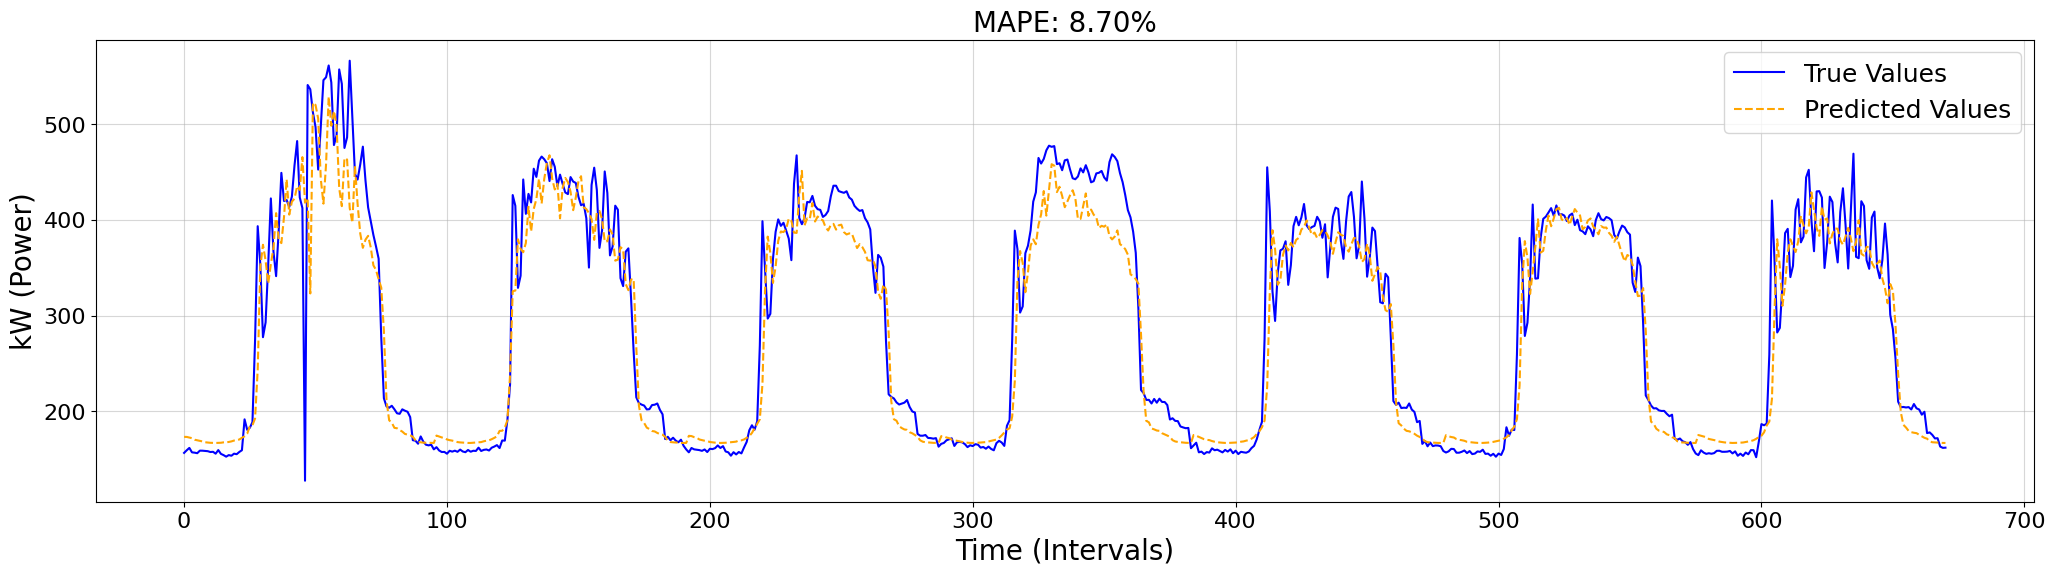

In [168]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_model(model, test_loader, criterion, scaler_y):
    model.eval()
    test_loss = 0.0
    true_values = []
    predicted_values = []

    with torch.no_grad():
        for X_enc, X_dec, y in test_loader:  
            output = model(X_enc, X_dec)  

            output = output.view(-1)

            loss = criterion(output, y.view(-1))  
            test_loss += loss.item() * X_enc.size(0)

            true_values.extend(y.cpu().numpy())
            predicted_values.extend(output.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    true_values = np.array(true_values)
    predicted_values = np.array(predicted_values)

    true_values = scaler_y.inverse_transform(true_values.reshape(-1, 1)).flatten()
    predicted_values = scaler_y.inverse_transform(predicted_values.reshape(-1, 1)).flatten()

    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    print(f'MAPE: {mape:.2f}%')

    return true_values, predicted_values, mape

true_values, predicted_values, mape = evaluate_model(model, test_loader, criterion, scaler_y)

plt.figure(figsize=(25, 6))
plt.plot(true_values, label='True Values', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='orange', linestyle='--')
plt.yticks(fontsize=16)  
plt.xticks(fontsize=16)  
plt.xlabel('Time (Intervals)', fontsize=20)
plt.ylabel('kW (Power)', fontsize=20)
plt.legend(fontsize=18)
plt.title(f'MAPE: {mape:.2f}%', fontsize=20)
plt.grid(alpha=0.5)  
plt.show()


# **Modify Code**

/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/1000, Training Loss: 0.1581
Epoch 1/1000, Validation Loss: 0.1107
Epoch 1/1000, Validation MAPE: 11.39%
Epoch 2/1000, Training Loss: 0.1252
Epoch 2/1000, Validation Loss: 0.1535
Epoch 2/1000, Validation MAPE: 18.35%
Epoch 3/1000, Training Loss: 0.1162
Epoch 3/1000, Validation Loss: 0.0704
Epoch 3/1000, Validation MAPE: 8.44%
Epoch 4/1000, Training Loss: 0.1220
Epoch 4/1000, Validation Loss: 0.0708
Epoch 4/1000, Validation MAPE: 9.54%
Epoch 5/1000, Training Loss: 0.1209
Epoch 5/1000, Validation Loss: 0.1261
Epoch 5/1000, Validation MAPE: 11.22%
Epoch 6/1000, Training Loss: 0.1165
Epoch 6/1000, Validation Loss: 0.0838
Epoch 6/1000, Validation MAPE: 8.77%
Epoch 7/1000, Training Loss: 0.1168
Epoch 7/1000, Validation Loss: 0.0862
Epoch 7/1000, Validation MAPE: 10.57%
Epoch 8/1000, Training Loss: 0.1201
Epoch 8/1000, Validation Loss: 0.1061
Epoch 8/1000, Validation MAPE: 12.20%
Epoch 9/1000, Training Loss: 0.1166
Epoch 9/1000, Validation Loss: 0.1023
Epoch 9/1000, Validation MAPE: 10

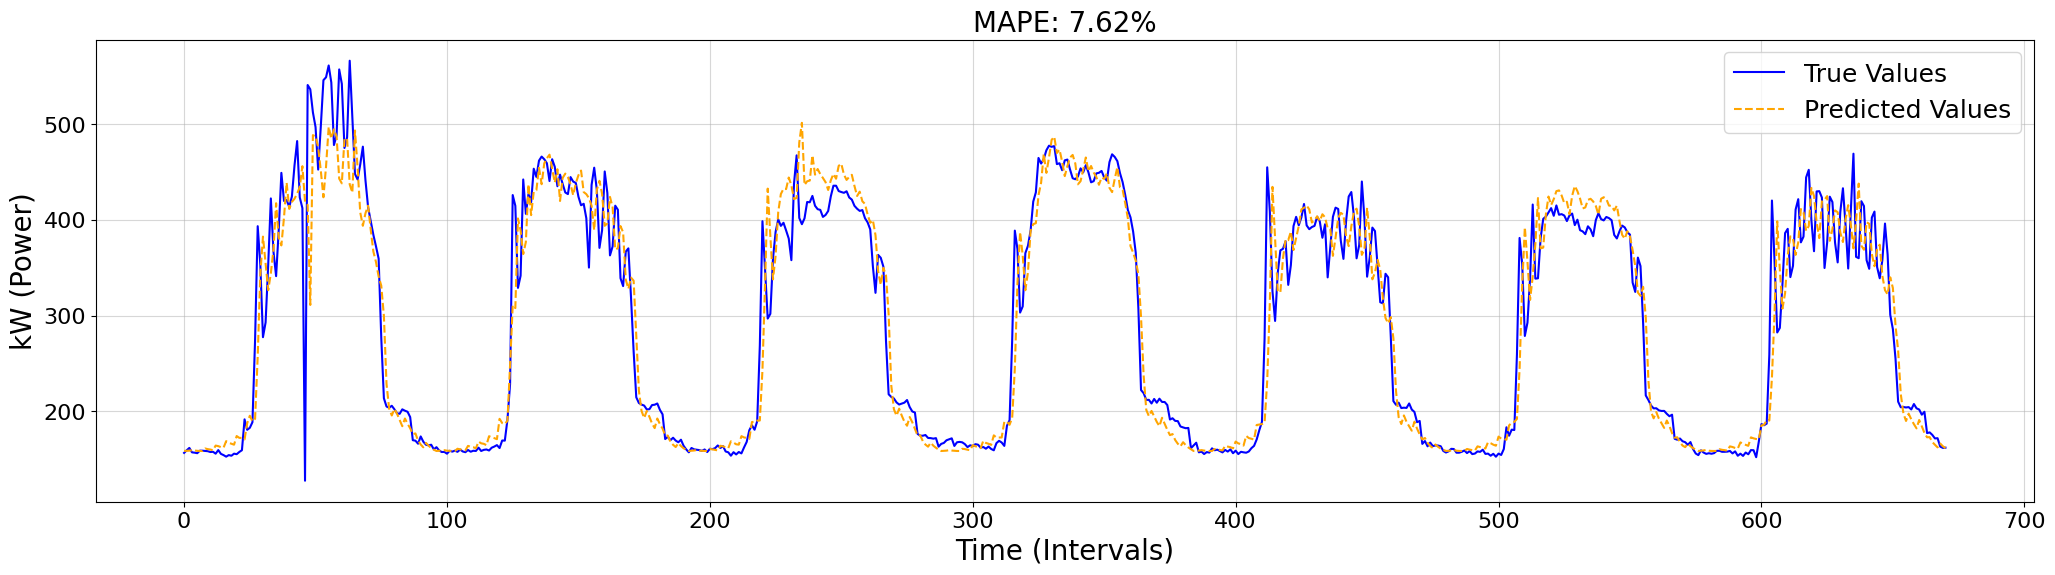

In [200]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Define Encoder
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

# Define Decoder
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

# Define MultiDeT model
class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.1):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        self.decoder = Decoder(decoder_layers, d_model=d_model, dropout=dropout)
        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model)
        )
        self.decoderLinear = nn.Sequential(
            nn.Linear(len(decoder_features), d_model),
            nn.BatchNorm1d(d_model)
        )

    def forward(self, src, src_dec):
        encoder_output = self.encoder(self.encoderLinear(src))
        decoder_output = self.decoder(encoder_output, self.decoderLinear(src_dec))
        return decoder_output

# Training function
def train_model_until_mape(model, train_loader, val_loader, criterion, optimizer, num_epochs=1000, target_mape=7):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_val_mape = float('inf')
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_dec, y in train_loader:
            optimizer.zero_grad()
            output = model(X_enc, X_dec)
            output = output.view(-1)
            loss = criterion(output, y.view(-1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_true_values = []
        val_predicted_values = []
        with torch.no_grad():
            for X_enc, X_dec, y in val_loader:
                output = model(X_enc, X_dec)
                output = output.view(-1)
                loss = criterion(output, y.view(-1))
                val_loss += loss.item() * X_enc.size(0)
                val_true_values.extend(y.cpu().numpy())
                val_predicted_values.extend(output.cpu().numpy())

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        # Calculate MAPE
        val_true_values = np.array(val_true_values)
        val_predicted_values = np.array(val_predicted_values)
        val_true_values = scaler_y.inverse_transform(val_true_values.reshape(-1, 1)).flatten()
        val_predicted_values = scaler_y.inverse_transform(val_predicted_values.reshape(-1, 1)).flatten()
        val_mape = np.mean(np.abs((val_true_values - val_predicted_values) / val_true_values)) * 100
        print(f'Epoch {epoch+1}/{num_epochs}, Validation MAPE: {val_mape:.2f}%')

        # Save the model if MAPE improves
        if val_mape < best_val_mape:
            best_val_mape = val_mape
            best_val_loss = val_loss
            best_model_wts = model.state_dict()

        # Stop training if MAPE is below the target
        if val_mape < target_mape:
            print(f"Training stopped as Validation MAPE reached below {target_mape}%.")
            break

    # Load the best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return train_losses, val_losses, best_val_mape

# Initialize model, optimizer, and criterion
model = MultiDeT()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.1)

# Train the model
train_losses, val_losses, best_mape = train_model_until_mape(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=1000, target_mape=8
)

# Evaluation function
def evaluate_model(model, test_loader, criterion, scaler_y):
    model.eval()
    test_loss = 0.0
    true_values = []
    predicted_values = []

    with torch.no_grad():
        for X_enc, X_dec, y in test_loader:
            output = model(X_enc, X_dec)
            output = output.view(-1)
            loss = criterion(output, y.view(-1))
            test_loss += loss.item() * X_enc.size(0)
            true_values.extend(y.cpu().numpy())
            predicted_values.extend(output.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    true_values = np.array(true_values)
    predicted_values = np.array(predicted_values)

    true_values = scaler_y.inverse_transform(true_values.reshape(-1, 1)).flatten()
    predicted_values = scaler_y.inverse_transform(predicted_values.reshape(-1, 1)).flatten()

    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    print(f'MAPE: {mape:.2f}%')

    return true_values, predicted_values, mape

# Evaluate the model
true_values, predicted_values, mape = evaluate_model(model, test_loader, criterion, scaler_y)

# Plot results
plt.figure(figsize=(25, 6))
plt.plot(true_values, label='True Values', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='orange', linestyle='--')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Time (Intervals)', fontsize=20)
plt.ylabel('kW (Power)', fontsize=20)
plt.legend(fontsize=18)
plt.title(f'MAPE: {mape:.2f}%', fontsize=20)
plt.grid(alpha=0.5)
plt.show()


In [201]:
torch.save(model.state_dict(), "best_model_weights.pth")
print("Model weights saved to best_model_weights.pth")
torch.save(model, "best_model.pth")
print("Entire model saved to best_model.pth")


Model weights saved to best_model_weights.pth
Entire model saved to best_model.pth


In [203]:
model = torch.load("best_model.pth")
model.eval()  # Chuyển sang chế độ đánh giá
print("Entire model loaded from best_model.pth")


Entire model loaded from best_model.pth


/var/folders/cm/nfg3lzjx1yb8gh0lpqtj20zc0000gn/T/ipykernel_5774/2579830322.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("best_model.pth")


Model loaded successfully.
MAPE: 7.62%


/var/folders/cm/nfg3lzjx1yb8gh0lpqtj20zc0000gn/T/ipykernel_5774/3459034977.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("best_model.pth")  # Load t

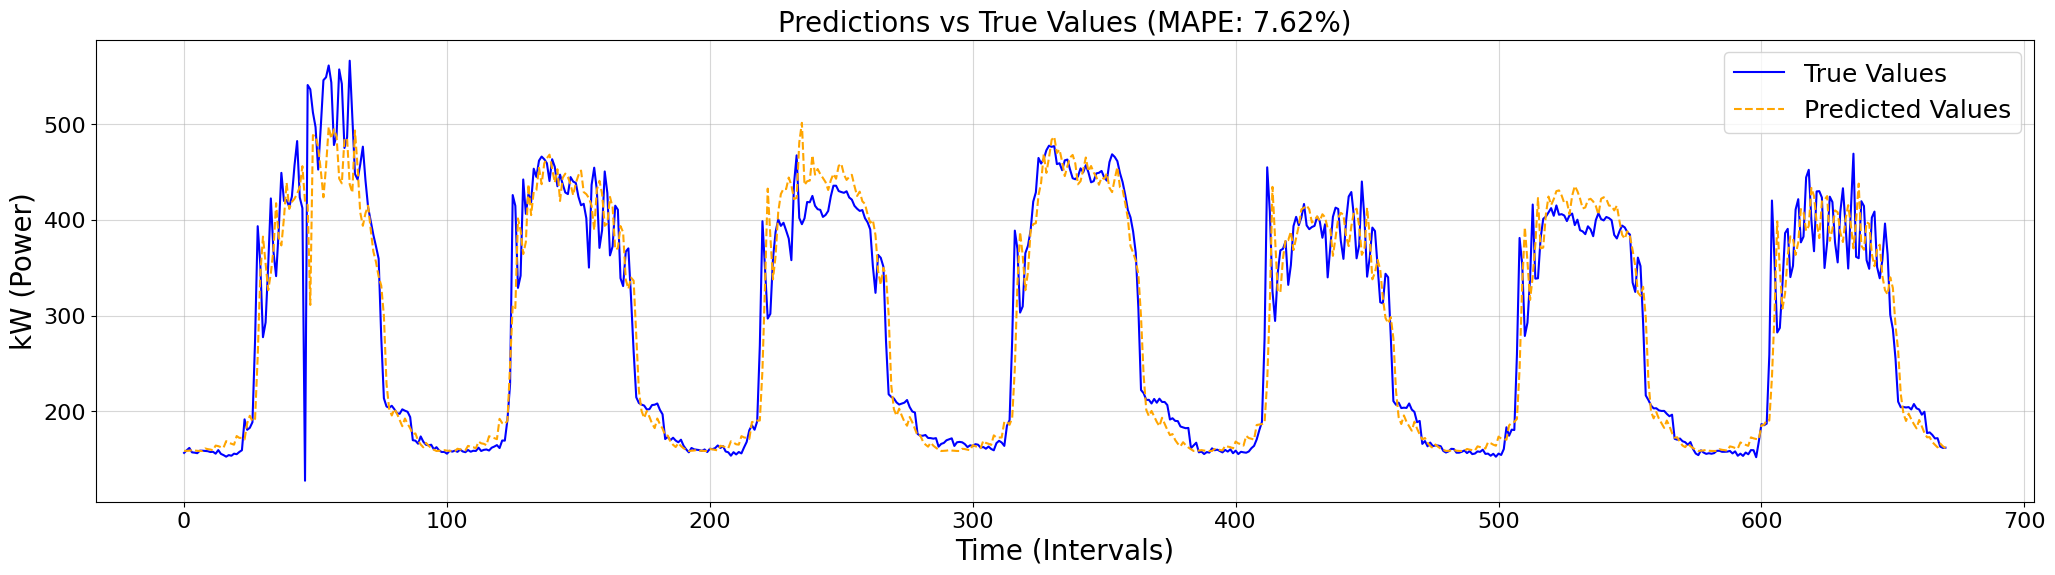

In [202]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = torch.load("best_model.pth")  # Load the entire model (if saved as a complete model)
model.eval()  # Switch to evaluation mode
print("Model loaded successfully.")

# Predict on test data
predictions = []
true_values = []

with torch.no_grad():
    for X_enc, X_dec, y in test_loader:
        output = model(X_enc, X_dec)  # Predict
        predictions.extend(output.cpu().numpy())  # Save predictions
        true_values.extend(y.cpu().numpy())  # Save true values

# Convert back to original scale if StandardScaler was used
predictions = np.array(predictions).flatten()
true_values = np.array(true_values).flatten()

predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
true_values = scaler_y.inverse_transform(true_values.reshape(-1, 1)).flatten()

# Calculate MAPE
mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100
print(f"MAPE: {mape:.2f}%")

# Plot predictions vs true values
plt.figure(figsize=(25, 6))
plt.plot(true_values, label='True Values', color='blue')
plt.plot(predictions, label='Predicted Values', color='orange', linestyle='--')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Time (Intervals)', fontsize=20)
plt.ylabel('kW (Power)', fontsize=20)
plt.legend(fontsize=18)
plt.title(f'Predictions vs True Values (MAPE: {mape:.2f}%)', fontsize=20)
plt.grid(alpha=0.5)
plt.show()
